In [ ]:
import numpy as np
import tensorflow_probability as tfp
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import matplotlib.pyplot as plt
import math
import os
import random
import string
import logging
import math
import cv2
import re 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pathlib

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
# connect to TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [2]:
images = []
file_names = []
for file_name in os.listdir('images'):
    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join('images', file_name)
        image = cv2.imread(image_path)[250:800, :550]
        image = cv2.resize(image, (256, 256))/255.
        # image = cv2.resize(image, (600, 600))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        file_names.append(file_name)

blurry = []
for ims in images:
    gaussian = cv2.GaussianBlur(ims, (15, 15), 0)
    blurry.append(gaussian)

In [ ]:
def save_images_to_folder(images, file_names, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, img in enumerate(images):
        output_path = os.path.join(output_folder, file_names[idx])
        cv2.imwrite(output_path, img * 255)
        print(f"Saved {output_path}")

save_images_to_folder(np.array(blurry), sorted_file_names, 'new_images')

In [15]:
def sort_images(image_name):
    number = re.search(r'(\d+)', image_name)
    if number:
        return int(number.group(1))
    return 0

sorted_file_names = sorted(file_names, key=sort_images)
index_of_sorted_file_names = [file_names.index(i) for i in sorted_file_names]

sorted_blurry = []
for file_name_index in index_of_sorted_file_names:
    sorted_blurry.append(blurry[file_name_index])

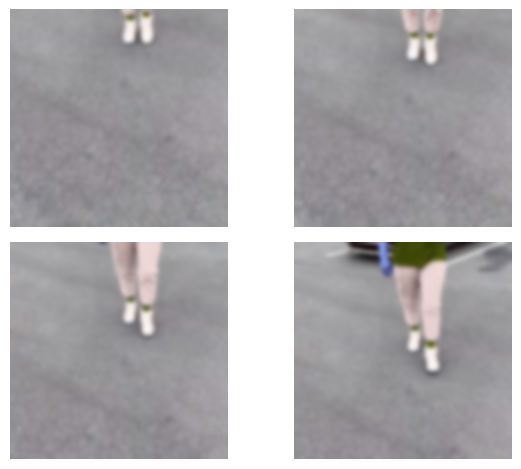

In [21]:
blurry = np.array(blurry)
images = np.array(images)
sorted_blurry = np.array(sorted_blurry)

plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(sorted_blurry[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
with strategy.scope():

    input = tf.keras.layers.Input(shape=(256, 256, 3))
    
    # Encoder
    x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    
    # Autoencoder
    autoencoder = tf.keras.models.Model(input, x)
    optimizer = tf.keras.optimizers.Adam(1e-5)

    checkpoint_path = './cnmjk_4auto'
    ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)


    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!!')

    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            ckpt_save_path = ckpt_manager.save()


    autoencoder.compile(optimizer=optimizer, loss="mse")
    
    autoencoder.fit(x=blurry, y=images, batch_size=128, epochs=100, callbacks=[CustomCallback()])

In [5]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units=128, activation='relu'):
        super(FeedForward, self).__init__()

        self.dense = tf.keras.layers.Dense(units)
        self.norm = tf.keras.layers.LayerNormalization()
        self.act = tf.keras.layers.Activation(activation)

    def call(self, inputs):
        outputs = self.dense(inputs)
        outputs = self.norm(outputs)
        outputs = self.act(outputs)

        return outputs


class SinusoidalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_dims=128, embedding_min_frequency=1.0, embedding_max_frequency=1000.0):
        super(SinusoidalEmbedding, self).__init__()

        self.embedding_min_frequency = embedding_min_frequency
        self.embedding_max_frequency = embedding_max_frequency
        self.embedding_dims = embedding_dims

    def call(self, x):

        frequencies = tf.exp(
        tf.linspace(tf.math.log(self.embedding_min_frequency),
                    tf.math.log(self.embedding_max_frequency),
                    self.embedding_dims // 2))

        angular_speeds = 2.0 * math.pi * frequencies
        embeddings = tf.concat(
            [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)],
            axis=3)

        return embeddings

class Block(tf.keras.layers.Layer):
    def __init__(self, filters=128, kernel_size=3, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_1 = tf.keras.layers.Conv2D(filters, 1, padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='swish')
        self.conv_3 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')

        self.norm_1 = tf.keras.layers.BatchNormalization(center=False, scale=False)


    def call(self, x_img):

        x_r = self.conv_1(x_img)

        x_out = self.norm_1(x_img)
        x_out = self.conv_2(x_out)
        x_out = self.conv_3(x_out)
        x_out += x_r

        return x_out
    
    def get_config(self, **kwargs):
        config = super().get_config(**kwargs)
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
        })
        return config
        
class UNet(tf.keras.models.Model):
    def __init__(self, out_channels=3, image_size=32, depth=3, copy_rate=0.999, init_filter=256):
        super(UNet, self).__init__(name='unet')

        self.depth = depth
        self.init_filter = init_filter
        self.up_and_down_filters = [128, 256, 256]
        self.mid_filters = [256, 256]
        self.image_shape = (image_size, image_size, out_channels)
        self.copy_rate = copy_rate
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

        self.min_signal_rate = 0.02
        self.max_signal_rate = 0.95

        self.norm = tf.keras.layers.Normalization(mean=0, variance=1)
        self.norm_1 = tf.keras.layers.Normalization(mean=0, variance=1)

        self.norm_group = tf.keras.layers.GroupNormalization()
        self.activation = tf.keras.activations.swish

        self.training_model = self.model_n(self.image_shape)
        self.generation_model = self.model_n(self.image_shape)

        self.conv_layers = [tf.keras.layers.Conv2D(self.init_filter, kernel_size=1, padding="same") for _ in range(4)] + [tf.keras.layers.Conv2D(3, kernel_size=1, padding="same")]
        self.num_channels = 3
        
        

    def model_n(self, image_shape,):

        image_with_noise = tf.keras.Input(shape=image_shape)
       
        time_steps = tf.keras.Input(shape=(1, 1, 1))
        t = SinusoidalEmbedding(embedding_dims=self.init_filter)(time_steps)
        x_ts = tf.keras.layers.UpSampling2D(size=image_shape[1], interpolation="nearest")(t)

        x = tf.keras.layers.Conv2D(self.init_filter, kernel_size=1, padding="same")(image_with_noise)
        x = tf.keras.layers.Concatenate()([x, x_ts])


        # down
        down_history = []
        for filter in self.up_and_down_filters:
            for _ in range(self.depth):
                x = Block(filter)(x)
                down_history.append(x)
            x = tf.keras.layers.MaxPool2D(2)(x)

        # mlp
        for filter in self.mid_filters:
            x = Block(filter)(x)

        # up
        for filter in reversed(self.up_and_down_filters):

            x = tf.keras.layers.UpSampling2D(2, interpolation="bilinear")(x)
            for _ in range(self.depth):
                x = tf.keras.layers.Concatenate()([x, down_history.pop()])
                x = Block(filter)(x)

        x = self.norm_group(x)
        x = self.activation(x)
        x = tf.keras.layers.Conv2D(image_shape[-1], kernel_size=1, padding="same", kernel_initializer="zeros")(x)

        return tf.keras.Model([image_with_noise, time_steps], x)

    def call(self, inputs, training):

        noisy_images, noise_rates, signal_rates = inputs

            
        if training:
            model_used = self.training_model
        else:
            model_used = self.generation_model

        pred_noises = model_used([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def train_step(self, inputs):
        
        high_q, low_q = inputs
        
        nbs = tf.shape(high_q)[0]
        high_q = self.norm_1(high_q)
        low_q = self.norm(low_q)

        noises = low_q


        diffusion_times = tf.random.uniform(shape=(nbs, 1, 1, 1), minval=0.0, maxval=1.0)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        
        # noises = (noisy_images - signal_rates * high_q)/noise_rates
        noisy_images = signal_rates * high_q + noise_rates * noises

        with tf.GradientTape() as tape:
            
            generated_noise, generated_image = self([noisy_images, noise_rates, signal_rates], training=True)
            loss = self._compute_loss(noises, generated_noise)

        grads = tape.gradient(loss, self.training_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.training_model.trainable_weights))

        for weight, ema_weight in zip(self.training_model.weights, self.generation_model.weights):
            ema_weight.assign(self.copy_rate * ema_weight + (1 - self.copy_rate) * weight)
            
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, real_noise, pred_noise):

        loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        loss = loss_object(real_noise, pred_noise)
        loss = tf.reduce_sum(loss)
        return loss

    def diffusion_schedule(self, diffusion_times):
        
        # diffusion times to angles
        start_angle = tf.acos(self.max_signal_rate)
        end_angle = tf.acos(self.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates

    def generate(self, initial_image, num_images=1, diffusion_steps=20):

        step_size = 1.0 / diffusion_steps

        next_noisy_images = self.norm(initial_image, training=False)
        # next_noisy_images = tf.random.normal((num_images, 256, 256, 3))

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self([noisy_images, noise_rates, signal_rates], training=False)

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)

        return pred_images

with strategy.scope():
    train_set = tf.data.Dataset.from_tensor_slices((images, blurry))
    train_set = train_set.batch(32, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)

    im_sh = blurry.shape
    model = UNet(out_channels=im_sh[-1], image_size=im_sh[-2])

    optimizer = tf.keras.optimizers.Adam(1e-6)

    checkpoint_path = './cnmjk_4c'
    ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)


    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!!')

    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            ckpt_save_path = ckpt_manager.save()


    model.compile(optimizer=optimizer)
    # model.fit(train_set, epochs=1000, callbacks=[CustomCallback()])

    
    

Latest checkpoint restored!!


72/72 [==============================] - 9s 96ms/step


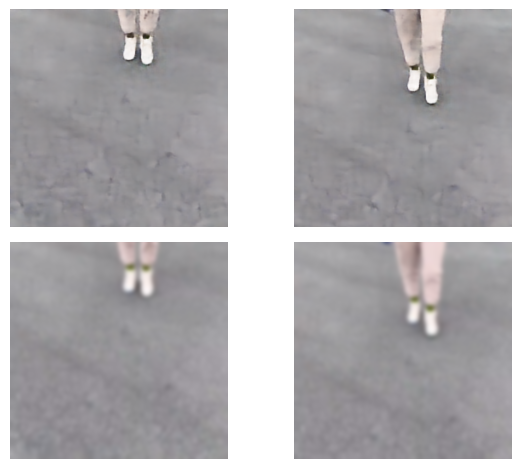

In [29]:
auto = True
with strategy.scope():

    if auto:
        ff = autoencoder.predict(sorted_blurry)
    
    else:  
        pred_images = model.generate(sorted_blurry[:50], num_images=50, diffusion_steps=10)
        x = (pred_images - np.min(pred_images))/(np.max(pred_images) - np.min(pred_images))
        ff = model.norm.mean + pred_images * model.norm.variance**0.5
        ff =  tf.clip_by_value(ff, 0.0, 1.0)


plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(np.concatenate([ff[1:3], sorted_blurry[1:3]])[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
def save_images_to_folder(images, file_names, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, img in enumerate(images):
        output_path = os.path.join(output_folder, file_names[idx])
        cv2.imwrite(output_path, img * 255)
        print(f"Saved {output_path}")

save_images_to_folder(np.array(ff), sorted_file_names, 'new_images')